In [1]:
import os
import glob
import pandas as pd
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql import DataFrame
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from sklearn.metrics import roc_auc_score, brier_score_loss
from scipy.stats import ks_2samp

## HELPER FUNCTIONS

In [2]:
def calculate_gini(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

def calculate_ks(y_true, y_pred):
    scores_pos = y_pred[y_true == 1]
    scores_neg = y_pred[y_true == 0]
    return ks_2samp(scores_pos, scores_neg).statistic

## LOAD DATA

In [3]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("ModelMonitoringBuilder") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/10 18:53:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### LABELS

In [4]:
LABEL_DIR = "/app/datamart/gold/label_store"
# Find subdirectories that look like *.parquet (folders, not files)
subfolders = sorted([os.path.join(LABEL_DIR, d) for d in os.listdir(LABEL_DIR) if d.endswith(".parquet")])

if not subfolders:
    raise FileNotFoundError(f"No label snapshot folders found in {LABEL_DIR}")

print(f"📂 Found {len(subfolders)} label snapshots")
label_store_sdf = spark.read.parquet(*subfolders)
print("✅ row_count:", label_store_sdf.count())

📂 Found 24 label snapshots


[Stage 1:>                                                          (0 + 8) / 8]

✅ row_count: 11459


### PREDICTIONS

In [5]:
# prepare arguments
prediction_dir = "/app/datamart/gold/model_predictions/LR/"

In [6]:
inference_data = None

for snapshot_date_str in ['2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01', '2025-01-01']:
    partition_name = f"predictions_{snapshot_date_str.replace('-', '_')}.csv"
    filepath = prediction_dir + partition_name
    df = spark.read.csv(filepath, header=True, inferSchema=True)
    print(f"✅ loaded from: {filepath}, rows: {df.count()}")

    if inference_data is None:
        inference_data = df
    else:
        inference_data = inference_data.unionByName(df)

print("📊 Total rows after append:", inference_data.count())

✅ loaded from: /app/datamart/gold/model_predictions/LR/predictions_2024_09_01.csv, rows: 493
✅ loaded from: /app/datamart/gold/model_predictions/LR/predictions_2024_10_01.csv, rows: 456
✅ loaded from: /app/datamart/gold/model_predictions/LR/predictions_2024_11_01.csv, rows: 488
✅ loaded from: /app/datamart/gold/model_predictions/LR/predictions_2024_12_01.csv, rows: 515
✅ loaded from: /app/datamart/gold/model_predictions/LR/predictions_2025_01_01.csv, rows: 526
📊 Total rows after append: 2478


In [7]:
inference_data.show(5)

+-----------+-------------+----------+--------------------+
|Customer_ID|snapshot_date|model_name|   model_predictions|
+-----------+-------------+----------+--------------------+
| CUS_0x1087|   2024-09-01|        LR|                 0.0|
| CUS_0x1138|   2024-09-01|        LR|                 0.0|
| CUS_0x121b|   2024-09-01|        LR|1.716813263218715...|
| CUS_0x1232|   2024-09-01|        LR|                 1.0|
| CUS_0x140e|   2024-09-01|        LR|                 0.0|
+-----------+-------------+----------+--------------------+
only showing top 5 rows



In [8]:
max_date = inference_data.agg(F.max("snapshot_date").alias("max_date")).collect()[0]["max_date"]
min_date = inference_data.agg(F.min("snapshot_date").alias("min_date")).collect()[0]["min_date"]

In [9]:
inference_data = inference_data.select('Customer_ID', 'snapshot_date', 'model_predictions')

In [10]:
inference_data = inference_data.toPandas()

In [11]:
# Convert snapshot_date to datetime if it's not already
inference_data['snapshot_date'] = pd.to_datetime(inference_data['snapshot_date'])

# Check unique months available
print("Available months:")
print(inference_data['snapshot_date'].dt.to_period('M').unique())

Available months:
<PeriodArray>
['2024-09', '2024-10', '2024-11', '2024-12', '2025-01']
Length: 5, dtype: period[M]


In [12]:
inference_data.head()

,Customer_ID,snapshot_date,model_predictions
0,CUS_0x1087,2024-09-01,0.000000e+00
1,CUS_0x1138,2024-09-01,0.000000e+00
2,CUS_0x121b,2024-09-01,1.716813e-275
3,CUS_0x1232,2024-09-01,1.000000e+00
4,CUS_0x140e,2024-09-01,0.000000e+00


### LABELS

In [13]:
# connect to label store
folder_path = "/app/datamart/gold/label_store/"
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
labels_df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",labels_df.count())

row_count: 11459


In [14]:
labels_df.show(10)

+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x10ac_2024_0...| CUS_0x10ac|    0|30dpd_1mob|   2024-09-01|
|CUS_0x10c5_2024_0...| CUS_0x10c5|    1|30dpd_1mob|   2024-09-01|
|CUS_0x1145_2024_0...| CUS_0x1145|    0|30dpd_1mob|   2024-09-01|
|CUS_0x11ac_2024_0...| CUS_0x11ac|    0|30dpd_1mob|   2024-09-01|
|CUS_0x122c_2024_0...| CUS_0x122c|    0|30dpd_1mob|   2024-09-01|
|CUS_0x1274_2024_0...| CUS_0x1274|    0|30dpd_1mob|   2024-09-01|
|CUS_0x1288_2024_0...| CUS_0x1288|    0|30dpd_1mob|   2024-09-01|
|CUS_0x12cc_2024_0...| CUS_0x12cc|    0|30dpd_1mob|   2024-09-01|
|CUS_0x1338_2024_0...| CUS_0x1338|    0|30dpd_1mob|   2024-09-01|
|CUS_0x1370_2024_0...| CUS_0x1370|    0|30dpd_1mob|   2024-09-01|
+--------------------+-----------+-----+----------+-------------+
only showing top 10 rows



In [15]:
# total and default counts
total_count = labels_df.count()
default_count = labels_df.filter(F.col("label") == 1).count()

default_rate = default_count / total_count if total_count > 0 else 0

print(f"📊 Default rate: {default_rate:.2%} ({default_count}/{total_count})")

📊 Default rate: 5.10% (584/11459)


In [16]:
labels_df = labels_df.select('Customer_ID', 'snapshot_date', 'label') \
                     .filter((col("snapshot_date") >= min_date) & (col("snapshot_date") <= max_date))
                     
labels_df.show(10)

+-----------+-------------+-----+
|Customer_ID|snapshot_date|label|
+-----------+-------------+-----+
| CUS_0x10ac|   2024-09-01|    0|
| CUS_0x10c5|   2024-09-01|    1|
| CUS_0x1145|   2024-09-01|    0|
| CUS_0x11ac|   2024-09-01|    0|
| CUS_0x122c|   2024-09-01|    0|
| CUS_0x1274|   2024-09-01|    0|
| CUS_0x1288|   2024-09-01|    0|
| CUS_0x12cc|   2024-09-01|    0|
| CUS_0x1338|   2024-09-01|    0|
| CUS_0x1370|   2024-09-01|    0|
+-----------+-------------+-----+
only showing top 10 rows



In [17]:
labels_df = labels_df.toPandas()

In [18]:
# Convert snapshot_date to datetime if it's not already
labels_df['snapshot_date'] = pd.to_datetime(labels_df['snapshot_date'])
labels_df.head()

,Customer_ID,snapshot_date,label
0,CUS_0x10ac,2024-09-01,0
1,CUS_0x10c5,2024-09-01,1
2,CUS_0x1145,2024-09-01,0
3,CUS_0x11ac,2024-09-01,0
4,CUS_0x122c,2024-09-01,0


In [19]:
spark.stop()

### MERGE

In [20]:
# Merge labels and predictions
inference_data = labels_df.merge(
    inference_data, 
    on=['Customer_ID'], 
    how='inner'
)
inference_data.head()

,Customer_ID,snapshot_date_x,label,snapshot_date_y,model_predictions
0,CUS_0x1087,2024-10-01,0,2024-09-01,0.000000e+00
1,CUS_0x1138,2024-10-01,0,2024-09-01,0.000000e+00
2,CUS_0x121b,2024-10-01,0,2024-09-01,1.716813e-275
3,CUS_0x1232,2024-10-01,0,2024-09-01,1.000000e+00
4,CUS_0x140e,2024-10-01,0,2024-09-01,0.000000e+00


## MONITORING

In [21]:
# Loop through each monitoring month
monitoring_results = []

for month in ['2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01', '2025-01-01']:
    # Filter data for this month
    month_data = inference_data[inference_data['snapshot_date_x'] == month]
    
    # Skip if no data for this month
    if len(month_data) == 0:
        print(f"Warning: No data found for {month}")
        continue
    
    y_true = month_data['label']
    y_pred = month_data['model_predictions']
    
    metrics = {
        "month": month,
        "n_samples": len(y_true),
        "AUC": round(roc_auc_score(y_true, y_pred), 4),
        "Gini": round(calculate_gini(y_true, y_pred), 4),
        "KS": round(calculate_ks(y_true, y_pred), 4),
        "Brier": round(brier_score_loss(y_true, y_pred), 4),
        "Pred_Mean": round(y_pred.mean(), 4),
        "Actual_Default_Rate": round(y_true.mean(), 4),
        "Default_Rate_Diff": round(abs(y_pred.mean() - y_true.mean()), 4)
    }
    
    monitoring_results.append(metrics)

# Convert to DataFrame
monitoring_df = pd.DataFrame(monitoring_results)
print("\n=== Monthly Monitoring Results ===")
print(monitoring_df.to_string(index=False))


=== Monthly Monitoring Results ===
     month  n_samples    AUC   Gini     KS  Brier  Pred_Mean  Actual_Default_Rate  Default_Rate_Diff
2024-10-01        493 0.5449 0.0899 0.1425 0.1777     0.1154               0.0710             0.0444
2024-11-01        456 0.6372 0.2743 0.3289 0.1237     0.0990               0.0439             0.0551
2024-12-01        488 0.5545 0.1090 0.1516 0.1837     0.1473               0.0492             0.0981


In [22]:
monitoring_directory = f"/app/datamart/gold/model_monitoring/"

if not os.path.exists(monitoring_directory):
    os.makedirs(monitoring_directory)

filepath = os.path.join(monitoring_directory, f"predictions_{min_date}_{max_date}.csv")
monitoring_df.to_csv(filepath, index=False)

## VISUALIZATION

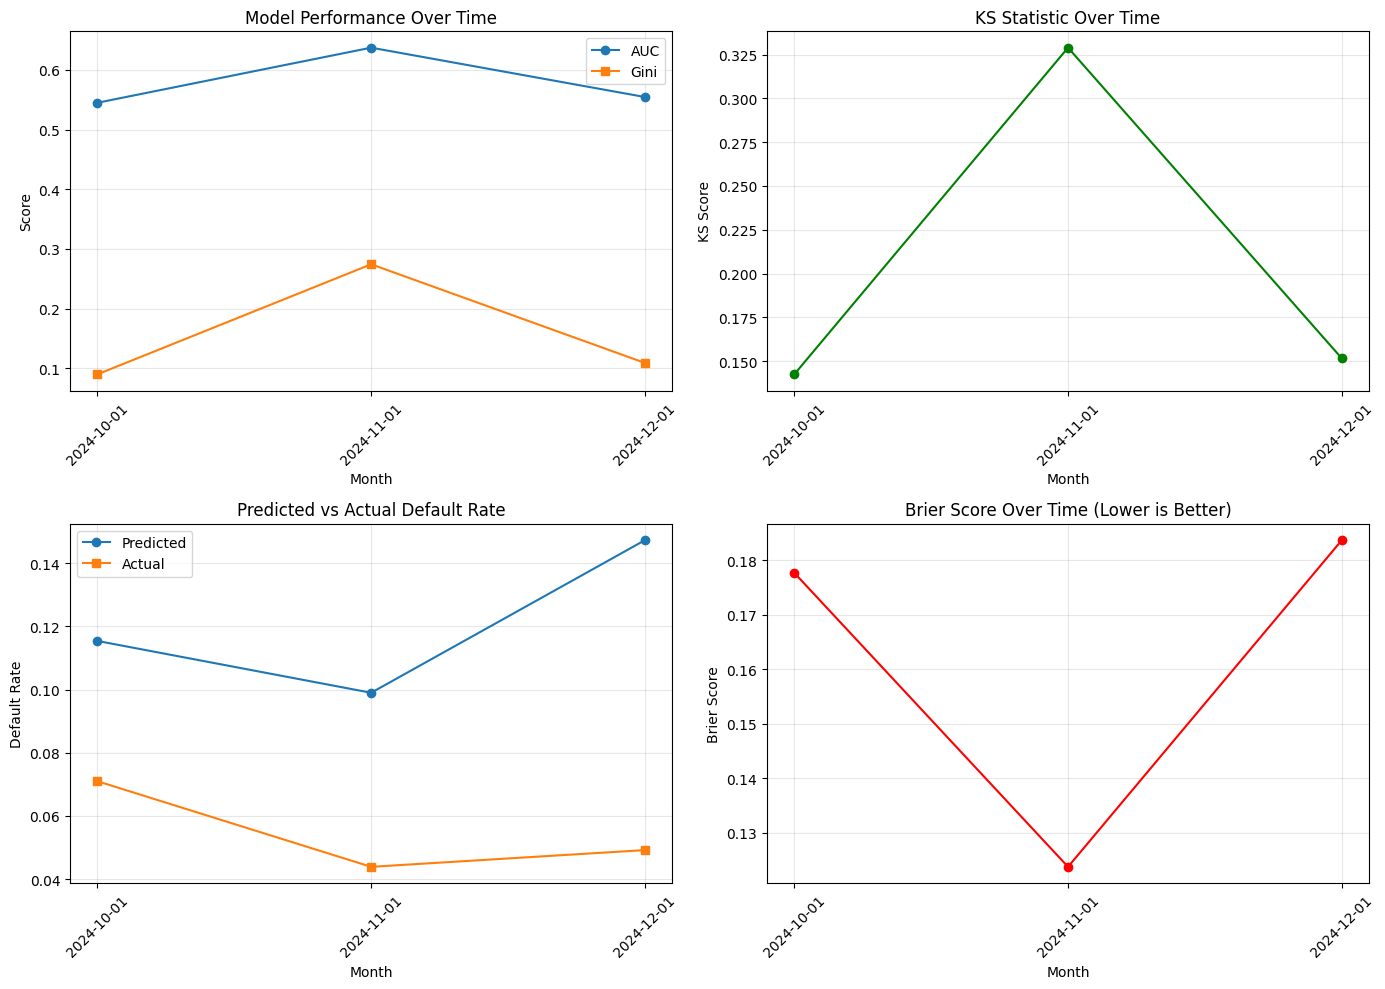

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: AUC and Gini over time
axes[0, 0].plot(monitoring_df['month'], monitoring_df['AUC'], marker='o', label='AUC')
axes[0, 0].plot(monitoring_df['month'], monitoring_df['Gini'], marker='s', label='Gini')
axes[0, 0].set_title('Model Performance Over Time')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Score')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: KS Statistic
axes[0, 1].plot(monitoring_df['month'], monitoring_df['KS'], marker='o', color='green')
axes[0, 1].set_title('KS Statistic Over Time')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('KS Score')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Predicted vs Actual Default Rate
axes[1, 0].plot(monitoring_df['month'], monitoring_df['Pred_Mean'], marker='o', label='Predicted')
axes[1, 0].plot(monitoring_df['month'], monitoring_df['Actual_Default_Rate'], marker='s', label='Actual')
axes[1, 0].set_title('Predicted vs Actual Default Rate')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Default Rate')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Brier Score
axes[1, 1].plot(monitoring_df['month'], monitoring_df['Brier'], marker='o', color='red')
axes[1, 1].set_title('Brier Score Over Time (Lower is Better)')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Brier Score')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
spark.stop()